#### Spotify Data Analysis 
 Thursday, December 14th
Jack Krebsbach & Eli Edwards

#### Import all libraries needed for analysis

We will use various models to predict song popularity and classify which playlist genre a song came from.

In [242]:
# Imports for analysis
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import plot_tree
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from ISLP import confusion_table
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestRegressor as RF,RandomForestClassifier as RFC, GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import sklearn.model_selection as skm

#### Import Data

In [243]:
# Read in the CSV
df = pd.read_csv("./clean_data/spotify_songs.csv")

# Transform categorical data
df['playlist_genre'] = df['playlist_genre'].astype('category')
df['key'] = df['key'].astype('category')
df['mode'] = df['mode'].astype('category')
numeric_cols = df.select_dtypes(include=['number'])
df[numeric_cols.columns] = numeric_cols.astype('float64')

In [244]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66.0,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67.0,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70.0,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60.0,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69.0,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052.0


### Plot first two principal components of data


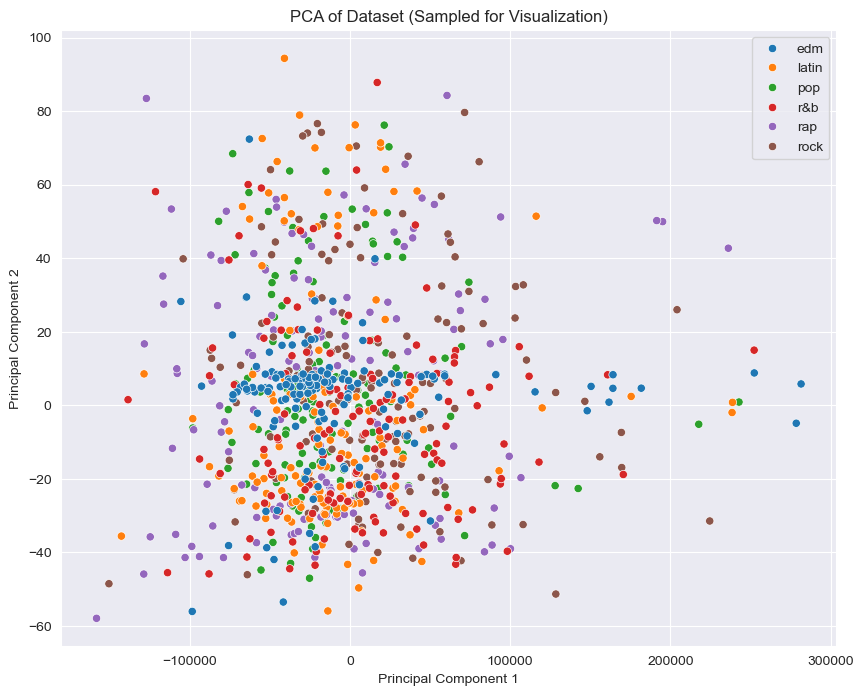

In [245]:
# Get the first two principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_cols)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['playlist_genre'] = df['playlist_genre'].values  # Ensure this column aligns with your PCA data


# Sample 150 points from each class for plotting
plot_df = pd.DataFrame()
for genre in pca_df['playlist_genre'].unique():
    sampled_genre_df = pca_df[pca_df['playlist_genre'] == genre].sample(n=150, random_state=42)
    plot_df = pd.concat([plot_df, sampled_genre_df], axis=0)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='playlist_genre', data=plot_df)
plt.title('PCA of Dataset (Sampled for Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#### Create train/test split

In [246]:
(train, test) = skm.train_test_split(df, test_size=0.10, random_state=0, stratify=df.playlist_genre)

### Make model matrix for classification

In [247]:
# Predictors
cols = ['track_popularity',
        'danceability',
        'energy',
        'key',
        'loudness',
        'mode',
        'speechiness',
        'acousticness',
        'instrumentalness',
        'liveness',
        'valence',
        'tempo',
        'duration_ms']

In [248]:
# Training
x_train = train[cols]
genre_train = train.playlist_genre

In [249]:
# Testing
x_test = test[cols]
genre_test = test.playlist_genre

### K-Nearest Neighbors

For a baseline, we try and fit a K-Nearest-Neighbors model.

In [250]:
# Use approximately the square root of number of observations
#k = int(np.floor(np.sqrt(x_train.shape[0])))
k = 20
print(f'Using {k} neighbors')
# Initialize classifier
knn = KNeighborsClassifier(n_neighbors=k) 
# Fit the model
knn.fit(x_train, genre_train)
# Predict on the testing set
knn_pred = knn.predict(x_test)
# Get confusion table
confusion_table(knn_pred, genre_test)

Using 20 neighbors


Truth,edm,latin,pop,r&b,rap,rock
Predicted,,,,,,
edm,270,148,161,132,150,117
latin,67,76,87,92,53,55
pop,90,99,125,69,90,74
r&b,58,60,65,104,100,90
rap,71,73,54,79,124,57
rock,48,60,59,67,58,102


In [251]:
# Get confusion matrix
np.mean(knn_pred == genre_test)

0.24390986601705236

##### Tune KNN Model

We will tune the KNN to find the optimal K from 1 to $\lfloor \sqrt{n} \rfloor$ where $n$ is the number of observations in the test set.

In [ ]:
# Clear plot
plt.clf()
# Range of k to try
k_range = range(1, int(np.floor(np.sqrt(x_train.shape[0]))) + 1)

# Lists to store accuracies
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, genre_train)

    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy.append(accuracy_score(genre_train, train_pred))

    # Testing accuracy
    test_pred = knn.predict(x_test)
    test_accuracy.append(accuracy_score(genre_test, test_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_accuracy, label='Training Accuracy')
plt.plot(k_range, test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Training and Testing Accuracy')
plt.legend()
plt.show()

#### LDA Classifier

In [ ]:
# Instantiate the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the model
lda.fit(x_train, genre_train)

# Predict on new data
lda_pred = lda.predict(x_test)

# Confusion matrix
cm = confusion_matrix(genre_test, lda_pred)
print(cm)

In [ ]:
# Get genre labels
genre_labels = genre_test.cat.categories.tolist()

# Coerce into data frame
cm_df = pd.DataFrame(cm, index=genre_labels, columns=genre_labels)
# Plot the DataFrame using matplotlib
fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size

# Hide axes
ax.axis('off')

# Add table to the figure
tbl = ax.table(cellText=cm_df.values, colLabels=cm_df.columns, rowLabels=cm_df.index, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.5, 1.5)  # Adjust the scale for better fitting

# Add labels for True Label and Predicted Label in the appropriate position
ax.text(-0.40, 0.5, 'Truth', va='center', ha='center', rotation='vertical', size=16, transform=ax.transAxes)
ax.text(0, 0.75, 'Predicted',size=16)


In [ ]:
# Testing Accuracy
accuracy_score(genre_test, lda_pred)

#### Random Forest

In [ ]:
# Instantiate classifier instance
rfc = RFC(random_state=0, n_estimators=500,  min_samples_leaf=10)
# Fit the data
rfc.fit(x_train, genre_train)
# Predict on new data
rfc_pred = rfc.predict(x_test)
# Confusion matrix
cm = confusion_matrix(genre_test, rfc_pred)
cm

In [ ]:
np.mean(rfc_pred == genre_test)

In [ ]:
# Extract the first tree from the forest
first_tree = rfc.estimators_[0]

# Plot the first tree
plt.figure(figsize=(20,10))
plot_tree(first_tree, filled=True, feature_names=x_train.columns, class_names=True)
plt.title("First Tree in the Random Forest")
plt.show()

##### Tune Parameters for Random Forest

In [ ]:
# Define Grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini',],
    'min_samples_leaf': [1, 2, 4, 10]
}
# 
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_features': ['sqrt'],
#     'max_depth': [4, 5, 6],
#     'criterion': ['gini'],
#     'min_samples_leaf': [2]
# }

In [ ]:
rfc = RFC(random_state=0)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(x_train, genre_train)

In [ ]:
print("Best Parameters found by GridSearchCV:")
print(CV_rfc.best_params_)

In [ ]:
# Assuming 'param_grid' has two parameters, for example: 'n_estimators' and 'max_depth'
results = pd.DataFrame(CV_rfc.cv_results_)
pivot_table = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title("Grid Search Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

In [ ]:
rfc_best = CV_rfc.best_estimator_
rfc_pred = rfc_best.predict(x_test)
cm = confusion_matrix(genre_test, rfc_pred)
print(cm)

In [ ]:
accuracy_score(genre_test,rfc_pred)

In [ ]:
# Get feature importance for random forest
feature_importances = rfc_best.feature_importances_

# If x_train is a DataFrame, get the feature names
feature_names = x_train.columns

# Coerce to data frame
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the top 3 features and their importances
print("Top 3 Feature Importances:")
print(importances_df.head(3))

#### XGBoost

In [ ]:
# Instantiate Label Encoder
pd.options.mode.chained_assignment = None
le_genre = LabelEncoder()
le_key = LabelEncoder()

# Encode testing set
y_encoded = le_genre.fit_transform(genre_train)
x_train.loc[:,'key'] = le_key.fit_transform(x_train.key)

# Encode training set
y_test_encoded = le_genre.transform(genre_test)
x_test.loc[:,'key'] = le_key.transform(x_test.key)

In [ ]:
# Instantiate the classifier
xg = xgb.XGBClassifier(enable_categorical = True)
# Fit the data
xg.fit(x_train, y_encoded) 
# Make prediction
xgb_pred = le_genre.transform(rfc.predict(x_test))
# Confusion Matrx
cm = confusion_matrix(y_test_encoded, xgb_pred)
cm

In [ ]:
# Get accuracy
np.mean(xgb_pred == y_test_encoded)

#### Now do a grid search in KV-fold cross validation 

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# param_grid = {
#     'max_depth': [3,2],
#     'n_estimators': [100],
#     'learning_rate': [0.2]
# }

In [ ]:
# Create a scorer
scorer = make_scorer(accuracy_score)

# Instantiate an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=0,enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss')

# Create GridSearchCV object
CV_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=scorer)

# Fit GridSearchCV
CV_xgb.fit(x_train, y_encoded)

# The best estimator after grid search
best_xgb_model = CV_xgb.best_estimator_

In [ ]:
# Plotting the heatmap of parameters
scores_df = pd.DataFrame(CV_xgb.cv_results_)
scores_df = scores_df.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(9, 6))
sns.heatmap(scores_df, annot=True, fmt=".3f", linewidths=.5, cmap='viridis')
plt.title('Grid Search Scores')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Max Depth')
plt.show()

In [ ]:
print("Best Parameters found by GridSearchCV:")
print(CV_xgb.best_params_)

In [ ]:
# Get feature importance for xgboost

# Get the feature importances from the model
feature_importances = best_xgb_model.feature_importances_

# If x_train is a DataFrame, get the feature names
feature_names = x_train.columns

# Combine the importances and names into a DataFrame and sort by importance
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the top 3 features and their importances
print("Top 3 Feature Importances:")
print(importances_df.head(3))